In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

for f in os.listdir("/content/drive/MyDrive"):
    if "Empyema" in f:
        print(f)

Mounted at /content/drive
Train Empyema.zip


In [ ]:
import zipfile
import os

# Assuming your zip file is in 'MyDrive/train_empyema.zip'
# Replace with the correct path if it's different
zip_path = '/content/drive/MyDrive/Train Empyema.zip'
extract_path = '/content/train_empyema' # specify the destination path

# Check if the zip file exists
if os.path.exists(zip_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Successfully unzipped '{zip_path}' to '{extract_path}'")
else:
  print(f"Error: Zip file not found at '{zip_path}'")

Successfully unzipped '/content/drive/MyDrive/Train Empyema.zip' to '/content/train_empyema'


In [ ]:
import os

base_path = "/content/train_empyema"

for root, dirs, files in os.walk(base_path):
    print(f"📁 Folder: {root} | Contains {len(files)} files")
    for d in dirs:
        print(f"  └── Subfolder: {d}")

📁 Folder: /content/train_empyema | Contains 0 files
  └── Subfolder: Train Empyema
📁 Folder: /content/train_empyema/Train Empyema | Contains 0 files
  └── Subfolder: Empyema
  └── Subfolder: No Findings
📁 Folder: /content/train_empyema/Train Empyema/Empyema | Contains 500 files
📁 Folder: /content/train_empyema/Train Empyema/No Findings | Contains 500 files


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Source folders
source_empyema = '/content/train_empyema/Train Empyema/Empyema'
source_no_finding = '/content/train_empyema/Train Empyema/No Findings'

# Target base directory
base_dir = '/content/split_data'
splits = ['train', 'val', 'test']
classes = ['empyema', 'no_finding']

# Make target folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Function to split and copy files
def split_and_copy(src_folder, class_name):
    files = os.listdir(src_folder)
    train_files, temp = train_test_split(files, test_size=0.30, random_state=42)
    val_files, test_files = train_test_split(temp, test_size=0.5, random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(base_dir, 'train', class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(base_dir, 'val', class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(base_dir, 'test', class_name, f))

# Split both classes
split_and_copy(source_empyema, 'empyema')
split_and_copy(source_no_finding, 'no_finding')

print("✅ Dataset split complete.")

✅ Dataset split complete.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 384
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 700 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S

base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3), pooling='avg')
base_model.trainable = False  # Freeze base for now

model = models.Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,332,641 (77.56 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
# Unfreeze the whole base model
base_model.trainable = True

# Compile again with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # 👈 Low LR
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,332,641 (77.56 MB)

 Trainable params: 20,178,769 (76.98 MB)

 Non-trainable params: 153,872 (601.06 KB)


🔁 Training from Epoch 1 to 5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.6112 - loss: 0.6571 - val_accuracy: 0.4933 - val_loss: 0.6941
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 926ms/step - accuracy: 0.7130 - loss: 0.6055 - val_accuracy: 0.8267 - val_loss: 0.5874
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 950ms/step - accuracy: 0.7917 - loss: 0.5339 - val_accuracy: 0.8600 - val_loss: 0.4407
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 925ms/step - accuracy: 0.8395 - loss: 0.4431 - val_accuracy: 0.8867 - val_loss: 0.3773
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 921ms/step - accuracy: 0.8657 - loss: 0.3625 - val_accuracy: 0.8733 - val_loss: 0.3463


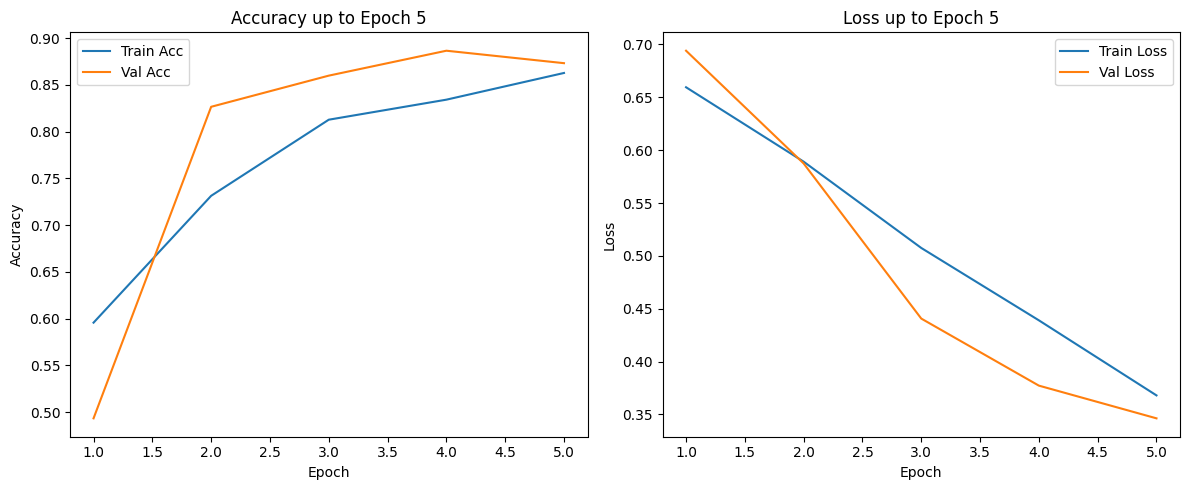

🧪 Testing after epoch 5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.8096 - loss: 0.3623
✅ Test Accuracy: 0.8600, Loss: 0.3112
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


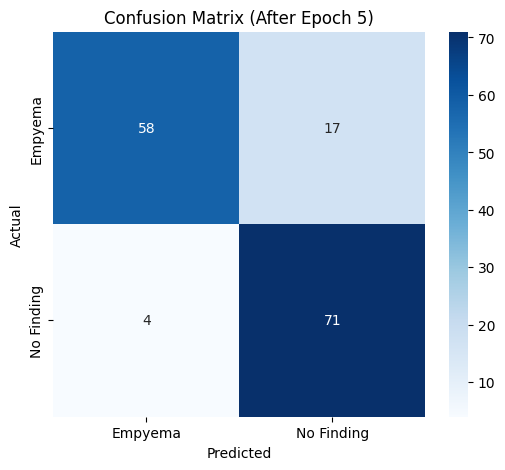


🔁 Training from Epoch 6 to 10
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 993ms/step - accuracy: 0.8702 - loss: 0.3419 - val_accuracy: 0.8400 - val_loss: 0.3450
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 923ms/step - accuracy: 0.9059 - loss: 0.2888 - val_accuracy: 0.8467 - val_loss: 0.3392
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 938ms/step - accuracy: 0.9018 - loss: 0.2804 - val_accuracy: 0.8667 - val_loss: 0.3151
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 920ms/step - accuracy: 0.9050 - loss: 0.2494 - val_accuracy: 0.8600 - val_loss: 0.3359
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 921ms/step - accuracy: 0.9231 - loss: 0.2356 - val_accuracy: 0.8800 - val_loss: 0.3246


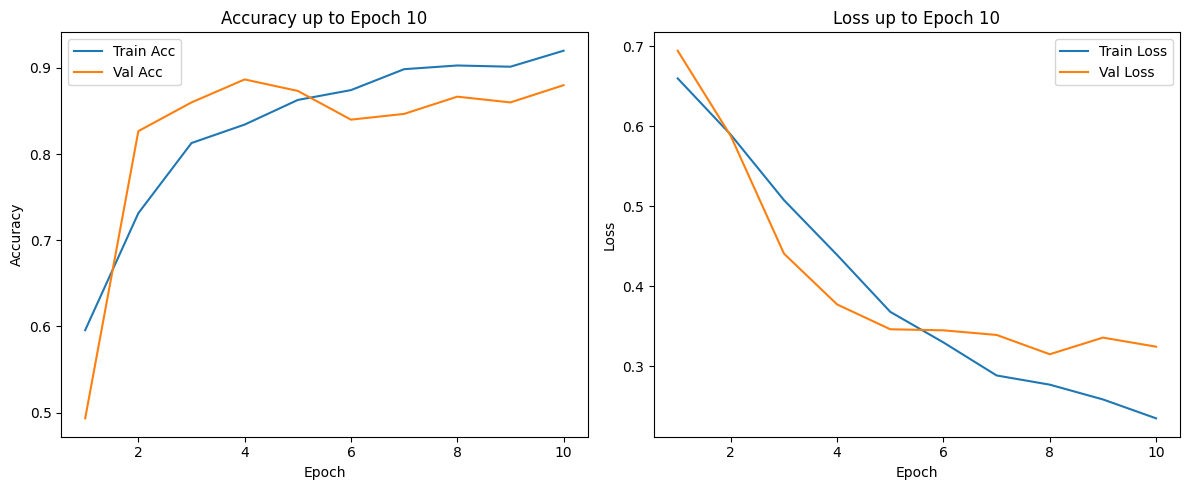

🧪 Testing after epoch 10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.8131 - loss: 0.3713
✅ Test Accuracy: 0.8733, Loss: 0.2654
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step


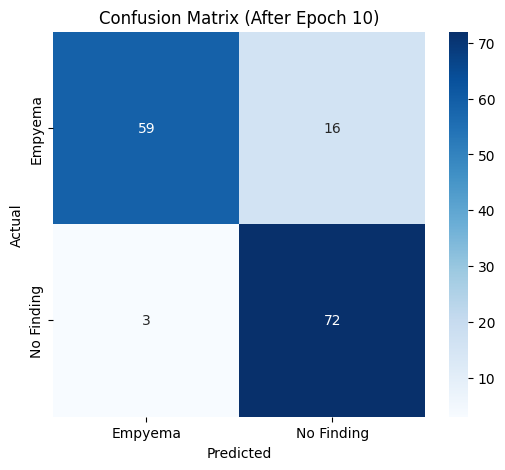


🔁 Training from Epoch 11 to 15
Epoch 11/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 942ms/step - accuracy: 0.9326 - loss: 0.1911 - val_accuracy: 0.8800 - val_loss: 0.2771
Epoch 12/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 940ms/step - accuracy: 0.9311 - loss: 0.1991 - val_accuracy: 0.8800 - val_loss: 0.2825
Epoch 13/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 942ms/step - accuracy: 0.9306 - loss: 0.1792 - val_accuracy: 0.8733 - val_loss: 0.2860
Epoch 14/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 913ms/step - accuracy: 0.9294 - loss: 0.2149 - val_accuracy: 0.8533 - val_loss: 0.3017
Epoch 15/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 933ms/step - accuracy: 0.9409 - loss: 0.1733 - val_accuracy: 0.8667 - val_loss: 0.2814


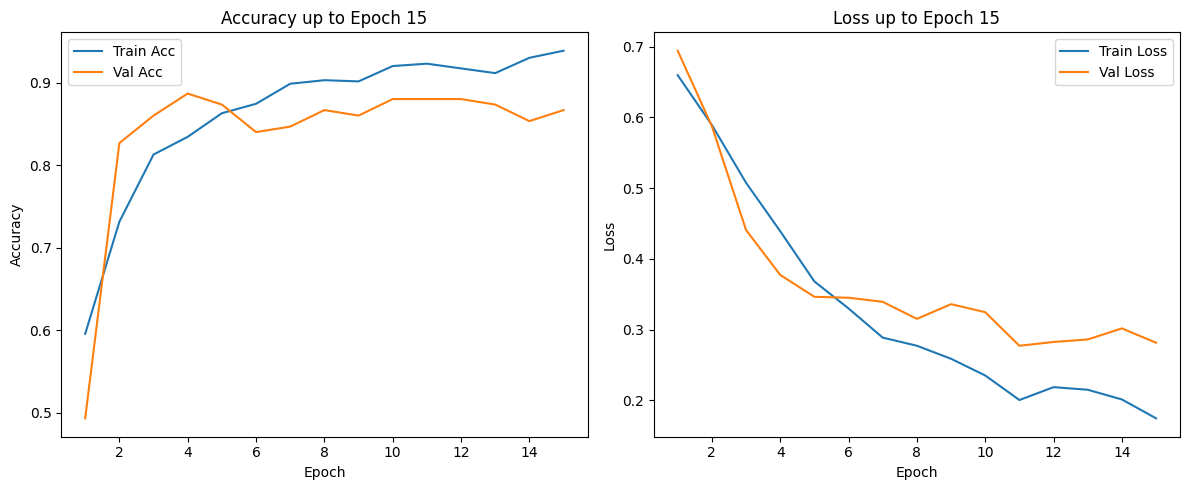

🧪 Testing after epoch 15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.8760 - loss: 0.2877
✅ Test Accuracy: 0.8933, Loss: 0.2219
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step


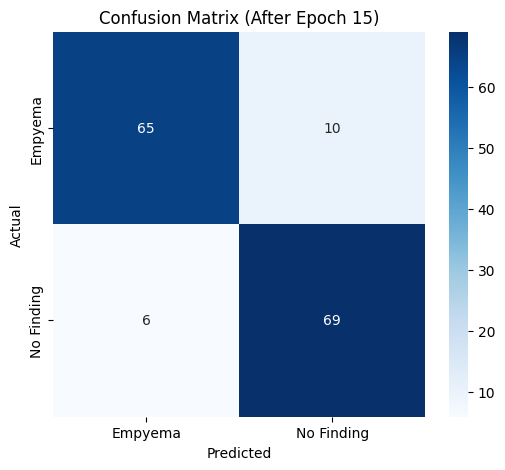


🔁 Training from Epoch 16 to 20
Epoch 16/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 941ms/step - accuracy: 0.9189 - loss: 0.2173 - val_accuracy: 0.8733 - val_loss: 0.3319
Epoch 17/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 81s 914ms/step - accuracy: 0.9513 - loss: 0.1537 - val_accuracy: 0.8733 - val_loss: 0.3303
Epoch 18/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 911ms/step - accuracy: 0.9463 - loss: 0.1472 - val_accuracy: 0.8733 - val_loss: 0.3261
Epoch 19/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 44s 979ms/step - accuracy: 0.9586 - loss: 0.1452 - val_accuracy: 0.8600 - val_loss: 0.3310
Epoch 20/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 925ms/step - accuracy: 0.9599 - loss: 0.1193 - val_accuracy: 0.8800 - val_loss: 0.3013


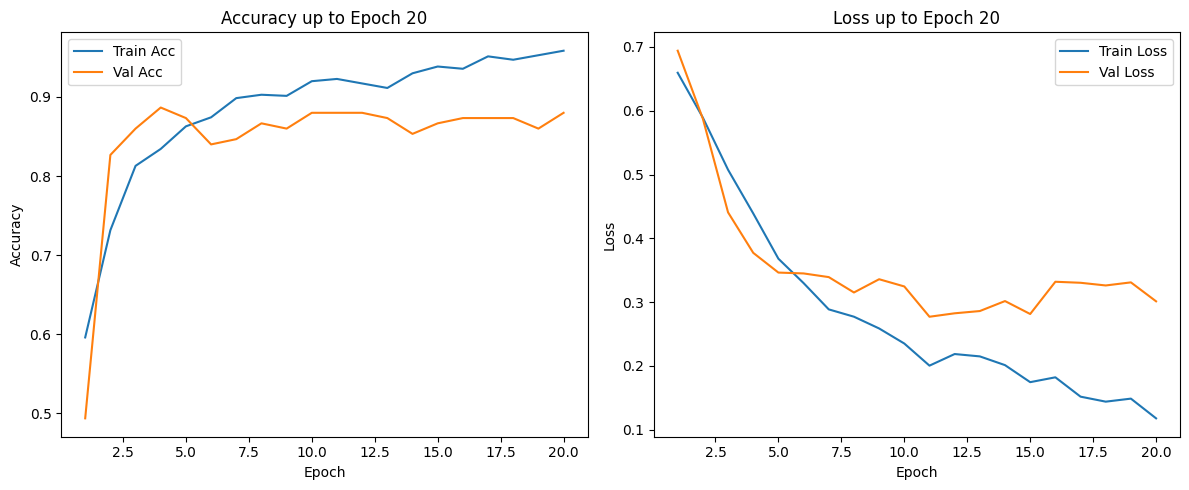

🧪 Testing after epoch 20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.8912 - loss: 0.2950
✅ Test Accuracy: 0.9133, Loss: 0.2372
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step


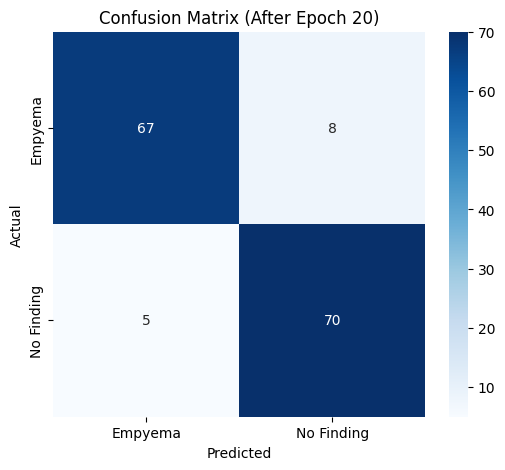

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

total_epochs = 20
history_all = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for i in range(0, total_epochs, 5):
    print(f"\n🔁 Training from Epoch {i+1} to {i+5}")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=i+5,
        initial_epoch=i,
        verbose=1
    )

    # Save metrics
    for key in history.history:
        history_all[key] += history.history[key]

    # Plot Accuracy & Loss
    epochs_range = range(1, i+6)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_all['accuracy'], label='Train Acc')
    plt.plot(epochs_range, history_all['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy up to Epoch {i+5}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_all['loss'], label='Train Loss')
    plt.plot(epochs_range, history_all['val_loss'], label='Val Loss')
    plt.title(f'Loss up to Epoch {i+5}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate on Test Data
    print("🧪 Testing after epoch", i+5)
    test_loss, test_acc = model.evaluate(test_gen)  # Use test_gen instead of test_data
    print(f"✅ Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

    # Confusion Matrix
    y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()  # Use test_gen instead of test_data
    y_true = test_gen.classes  # Access classes from test_gen

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Empyema', 'No Finding'],
                yticklabels=['Empyema', 'No Finding'])
    plt.title(f'Confusion Matrix (After Epoch {i+5})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.8912 - loss: 0.2950
✅ Fine-tuned Test Accuracy: 0.91
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step


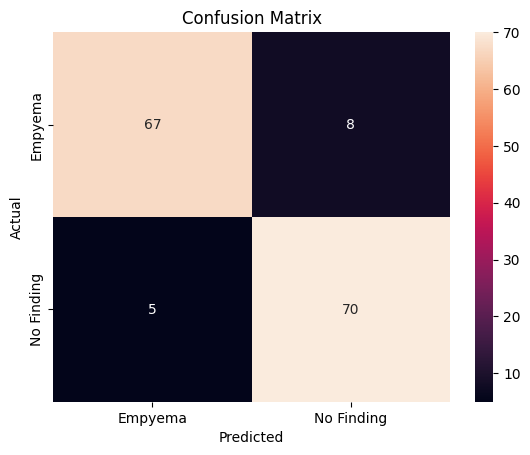

              precision    recall  f1-score   support

     Empyema       0.93      0.89      0.91        75
  No Finding       0.90      0.93      0.92        75

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



In [ ]:
# Evaluate on test set
import os  # Added this line
import shutil  # Added this line
from sklearn.model_selection import train_test_split  # Added this line
import tensorflow as tf  # Added this line
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Added this line
from tensorflow.keras import layers, models  # Added this line
from tensorflow.keras.applications import EfficientNetV2S  # Added this line
import matplotlib.pyplot as plt  # Added this line
import seaborn as sns  # Added this line
from sklearn.metrics import classification_report, confusion_matrix # Added this line to import confusion_matrix


loss, acc = model.evaluate(test_gen)
print(f"✅ Fine-tuned Test Accuracy: {acc:.2f}")

# Confusion matrix
y_pred = model.predict(test_gen)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Empyema','No Finding'], yticklabels=['Empyema','No Finding'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_labels, target_names=['Empyema', 'No Finding']))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff
import plotly.graph_objs as go

# 🔍 Evaluate model
loss, acc = model.evaluate(test_gen)
print(f"✅ Fine-tuned Test Accuracy: {acc:.2f}")

# 🔍 Predict
y_pred = model.predict(test_gen)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
y_true = test_gen.classes

# 🔍 Confusion Matrix (Plotly Heatmap)
cm = confusion_matrix(y_true, y_pred_labels)
labels = ['Empyema', 'No Finding']

fig_cm = ff.create_annotated_heatmap(
    z=cm,
    x=labels,
    y=labels,
    annotation_text=cm.astype(str),
    colorscale='Blues',
    showscale=True
)
fig_cm.update_layout(
    title='📊 Confusion Matrix (Plotly)',
    xaxis_title='Predicted Label',
    yaxis_title='True Label',
    width=500,
    height=500
)
fig_cm.show()

# 🔍 Classification Report (Optional Table)
report_dict = classification_report(y_true, y_pred_labels, target_names=labels, output_dict=True)
report_data = [
    [label,
     f"{metrics['precision']:.2f}",
     f"{metrics['recall']:.2f}",
     f"{metrics['f1-score']:.2f}",
     f"{int(metrics['support'])}"]
    for label, metrics in report_dict.items() if label in labels
]

table_fig = ff.create_table(
    [['Class', 'Precision', 'Recall', 'F1-Score', 'Support']] + report_data
)
table_fig.update_layout(title='📋 Classification Report')
table_fig.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.8912 - loss: 0.2950
✅ Fine-tuned Test Accuracy: 0.91
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step


In [ ]:
from sklearn.metrics import classification_report
import plotly.graph_objs as go

# 🔍 Classification Report in Dict Format
labels = ['Empyema', 'No Finding']
report_dict = classification_report(y_true, y_pred_labels, target_names=labels, output_dict=True)

# 🎯 Extract values
precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1 = [report_dict[label]['f1-score'] for label in labels]
support = [report_dict[label]['support'] for label in labels]

# 📊 Plotly Bar Graph
fig = go.Figure()

fig.add_trace(go.Bar(x=labels, y=precision, name='Precision', marker_color='royalblue'))
fig.add_trace(go.Bar(x=labels, y=recall, name='Recall', marker_color='orange'))
fig.add_trace(go.Bar(x=labels, y=f1, name='F1-Score', marker_color='green'))

fig.update_layout(
    title='📊 Precision, Recall, F1-Score (Per Class)',
    xaxis_title='Class',
    yaxis_title='Score',
    barmode='group',
    yaxis=dict(range=[0,1]),
    width=700,
    height=500
)
fig.show()


<ipython-input-22-f5d898cae082>:25: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

<ipython-input-22-f5d898cae082>:25: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.



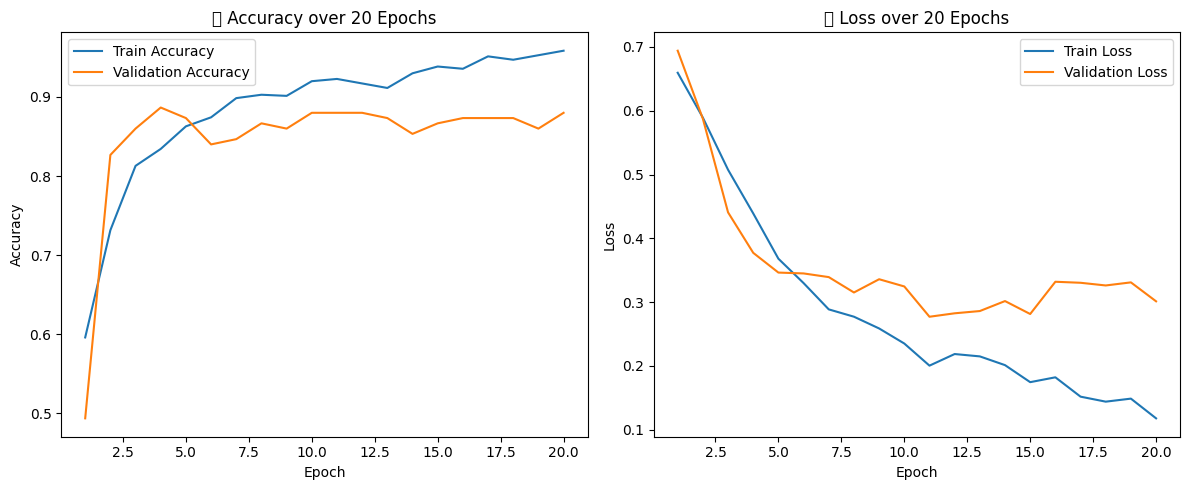

In [ ]:
# Graph: Accuracy and Loss for All 20 Epochs
total_epochs = 20  # Define total_epochs here
epochs_range = range(1, total_epochs + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_all['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history_all['val_accuracy'], label='Validation Accuracy')
plt.title('📈 Accuracy over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_all['loss'], label='Train Loss')
plt.plot(epochs_range, history_all['val_loss'], label='Validation Loss')
plt.title('📉 Loss over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objs as go
import plotly.subplots as sp

epochs_range = list(range(1, total_epochs + 1))

# Create subplot: 1 row, 2 columns
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

# Accuracy Plot
fig.add_trace(go.Scatter(x=epochs_range, y=history_all['accuracy'],
                         mode='lines+markers', name='Train Accuracy'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=epochs_range, y=history_all['val_accuracy'],
                         mode='lines+markers', name='Validation Accuracy'),
              row=1, col=1)

# Loss Plot
fig.add_trace(go.Scatter(x=epochs_range, y=history_all['loss'],
                         mode='lines+markers', name='Train Loss'),
              row=1, col=2)
fig.add_trace(go.Scatter(x=epochs_range, y=history_all['val_loss'],
                         mode='lines+markers', name='Validation Loss'),
              row=1, col=2)

fig.update_layout(title_text="📊 Model Accuracy & Loss (Interactive)",
                  width=1000, height=500, showlegend=True)
fig.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# 🔍 ROC Curve Data
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# 🔍 Classification Report Data
labels = ['Empyema', 'No Finding']
report_dict = classification_report(y_true, y_pred_labels, target_names=labels, output_dict=True)

precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1 = [report_dict[label]['f1-score'] for label in labels]

# 📊 Create Subplots (1 row, 2 columns)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("ROC Curve", "Precision, Recall, F1-Score"),
    horizontal_spacing=0.2
)

# ➤ ROC Curve
fig.add_trace(
    go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC AUC = {roc_auc:.2f}', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')),
    row=1, col=1
)

# ➤ Metrics Bar Chart
fig.add_trace(go.Bar(x=labels, y=precision, name='Precision', marker_color='royalblue'), row=1, col=2)
fig.add_trace(go.Bar(x=labels, y=recall, name='Recall', marker_color='orange'), row=1, col=2)
fig.add_trace(go.Bar(x=labels, y=f1, name='F1-Score', marker_color='green'), row=1, col=2)

# 🎨 Layout
fig.update_layout(
    title='📈 Combined ROC + Classification Metrics',
    width=1000,
    height=500,
    showlegend=True,
    barmode='group',
)

fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.update_xaxes(title_text="Class", row=1, col=2)
fig.update_yaxes(title_text="Score", range=[0, 1], row=1, col=2)

fig.show()


In [ ]:
import plotly.graph_objects as go

# Class labels
labels = ['Empyema', 'No Finding']

# Tumhare classification_report se extracted metrics (manually set)
precision = [0.93, 0.90]
recall = [0.89, 0.93]
f1_score = [0.91, 0.92]

# Create Plotly bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=labels, y=precision, name='Precision', marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=labels, y=recall, name='Recall', marker_color='orange'
))
fig.add_trace(go.Bar(
    x=labels, y=f1_score, name='F1-Score', marker_color='seagreen'
))

# Update layout
fig.update_layout(
    title='📊 Precision, Recall, F1-Score (Per Class)',
    xaxis_title='Class',
    yaxis_title='Score',
    yaxis=dict(range=[0, 1.1]),
    barmode='group',
    template='plotly_white',
    width=700,
    height=500
)

fig.show()


In [ ]:
model.save('model.h5')
from google.colab import files
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import plotly.graph_objects as go

# Model names and accuracies
models = ["My Model", "AlexNet", "GoogleNet", "SqueezeNet", "DarkNet19"]
accuracies = [94.0, 88.61933, 88.73081, 88.7264, 88.86]

# Colors: Highlight "My Model"
colors = ['steelblue' if model == "My Model" else 'lightblue' for model in models]

# Create bar chart
fig = go.Figure(data=[
    go.Bar(
        x=models,
        y=accuracies,
        marker_color=colors,
        text=[f"{acc:.2f}%" for acc in accuracies],
        textposition='auto',
        hovertemplate='Model: %{x}<br>Accuracy: %{y:.2f}%<extra></extra>'
    )
])

# Layout
fig.update_layout(
    title='📊 Model Accuracy Comparison',
    xaxis_title='Models',
    yaxis_title='Accuracy (%)',
    yaxis=dict(range=[85, 96]),
    template='plotly_white',
    font=dict(size=16),
    height=500
)

# Show interactive chart
fig.show()
